## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares,minimize
from scipy.integrate import simpson
import pickle
import pdb
import MDAnalysis as mda
from scipy.integrate import quad, simpson, trapezoid
from timeit import default_timer as timer

## Defining variables and constants

Parameters to define before analysis

In [2]:
N_s = 217 #Number of ions used
k = 0.785  # units: kJ/mol/nm^2 - force constant being used in calculations
L_x, L_y, L_z = 4.8, 4.8, 14.4
T = 300  # units: K - temperature used for calculations

Constants

In [3]:
NA = 6.02214076E23  # Avogadro's number
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant

## Calculating eq 12

$$ ln \left[ \frac{C_{s}(z)}{C_{max}} \right] + A \left[ \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} - \frac{C_{s}(z)^{1/2}}{1+BC_{s}(z)^{1/2}} \right] + \sum^{i_{max}}_{i=1} \alpha_{i} [C_{s}(z)^{i} - C_{max}^{i}] = - \frac {U(z)}{RT}$$

In [4]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = -A * np.sqrt(x) / (1 + theta[0] * np.sqrt(x))
    term_3 = A * np.sqrt(C_max) / (1 + theta[0] * np.sqrt(C_max))
    term_4 = theta[1]* (x - C_max) 
    term_5 = theta[2] * (x ** 2 - C_max ** 2)
    y = term_1 + term_2 + term_3 + term_4 + term_5

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [5]:
A = 1.7964  # in M^(-1/2), value based on Debye Huckel equations.

# Converting the units for A so that they are nm-based
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
A /= (conversion_factor ** 0.5)

## Maximum Likelihood Parameter Optimization

The basic idea of maximum likelihood parameter optimization is to express the probability of parameters given the data, $P(a|x)$, and using Bayes' rule to find that 

$P(a|x) = \frac{P(x|a)P(a)}{P(x)}$

We want to find the parameters 
$P(x)$ does not depend on the parameters. If we assume no prior information about the parameters $P(a)$ (that would be Bayesian inference), then we have

$P(a|x) \propto P(x|a)$.

So we need to maximize the probability given the data $P(\vec{x}|a)$. Assuming the samples are independent, then the total probability given all of the data is $\prod_{i=1}^N P(x_i|a)$.  

Since the logarithm is a monotonic function, then maximizing $\ln P(\vec{x}|a) = \sum_{i=1}^N \ln P(x_i|a)$ is the same as maximizing $P(\vec{x}|a$).

## Importing input data

In [6]:
u = mda.Universe('md.pdb', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname NA CL')

u1 = mda.Universe('mdr1.pdb', 'mdr1.xtc')
u1.transfer_to_memory()
ions1= u1.select_atoms('resname NA CL')

u2 = mda.Universe('mdr2.pdb', 'mdr2.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname NA CL')

u3 = mda.Universe('mdr3.pdb', 'mdr3.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname NA CL')

/home/bamo6610/miniconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [7]:
def get_ion_array(u,ions):
    """
    Funciton to get array of ion's z coordinate positions throughout trajectory of all samples.
    """
    ion_array=[]
    for ts in u.trajectory:
        ions_z = ions.positions[:,2]
        ion_array.append(ions_z)
    ionz = np.abs(np.array(ion_array)-72)/10  # rescale the data, setting the half of the length of the box to zero
    zvals=ionz.flatten()
    return zvals

# Get dictionary of zvalues for each sample
zvals={}
zvals['original']=get_ion_array(u,ions)
zvals['r1']=get_ion_array(u1,ions1)
zvals['r2']=get_ion_array(u2,ions2)
zvals['r3']=get_ion_array(u3,ions3)

# Get ion array containing all samples
zvals_all=[
    *zvals['original'],
    *zvals['r1'],
    *zvals['r2'],
    *zvals['r3'],
]

zvals_all=np.array(zvals_all)


For this problem, we are essentially finding the parameters that examine the probability of finding an ion at a given $z$ coordinate, since concentration is proportional to probability.  

We convert the concentration $C(z)/C_{max}$ to an unnormalized probability $p(z)$.  

$\ln p(z|B,\alpha_1,\alpha_2) \propto \ln \frac{C(z)}{C_{max}}$

$\ln \frac{C(z)}{C_{max}} = \sum_i -\frac{kz^2}{2RT} + A\left(\frac{C(z)^{1/2}}{1+BC(z)^{1/2}} - \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} \right) -\alpha_1(C(z)-C_{max}) - \alpha_2(C(z)^2-C_{max}^2)$  



$C_{max}$ and also the normalizing constant will be fixed by the fact that we have a fixed number of ions present.

This is actually not ideal for maximizing, since the concentration $c(z)$ occurs on both sides. It would be great if we could algebraically solve for $c(z)$, but this does not appear to be possible.

We can't actually leave out any of the terms, because all of the terms involve the parameters implicitly (including $C_{max}$).

We approach the problem the following way:

 - Given a set $[B,\alpha_1,\alpha_2]$, find the concentration $C(z|B,\alpha_1,\alpha_2)$ that satisfies those parameters. 
 - This will need to be done self-consistently, as each time the parameters change, $C_{max}$ will also change.
 - We will make use of a reference ideal distribution with no parameters.


### Normalization

Define the ideal solution function which satisfies the normalization and find the $C_{max}$ for this solution, i.e. 

$N_p = L_x L_y C_{max} \int_0^{\infty} p(z|B,\alpha_1,\alpha_2) dz$

$C_{max} = \frac{ N_p }{L_x L_y} \left(\int_0^{\infty} p(z|B,\alpha_1,\alpha_2\right) dz )^{-1}$

In [8]:
red_U_app = lambda z: 1000*k*z*z/(2*R*T) #left side of eq 12
cz_ideal = lambda z: np.exp(-red_U_app(z)) 

Can we leave only the integration code below?

In [9]:
ideal_norm = quad(cz_ideal,0,10)[0] #Integrate ideal concentration function from 0 to 10
print(ideal_norm)
# ideal_norm = np.sqrt(np.pi*R*T/(2*1000*k))
# print(ideal_norm)

2.2341010940709776


In [10]:
cmax_ideal=N_s/(L_x*L_y*ideal_norm)
print(cmax_ideal)

4.215746012019344


### Calculation funcitons

In [11]:
def czfunc(a,z,cz):
    """
    Function that iterates the calculation of a concentration.
    """
    cznew = np.exp(logprobfunc(a,z,cz))  # exponential of eq 12 for ln c/cmax for the data points
    zunique,locs = np.unique(z,return_index=True)  # now we have sorted unique points, we can integrate
    newarea = simpson(cznew[locs],x=zunique) # integrate
    cznorm_ratio = ideal_norm/newarea # get normalization ratio
    return (cmax_ideal*cznorm_ratio)*cznew

In [12]:
def logprobfunc(a,z,cz,A=A):
    """
    Function that calculates maximum concentration.
    """
    cmax = np.max(cz) # this only works if a sample is at z=0: improve!                      
    czh = np.sqrt(cz)
    cmaxh = np.sqrt(cmax)
    term_1 = -red_U_app(z)
    term_2 = A*((czh/(1+a[0]*czh))-(cmaxh/(1+a[0]*cmaxh)))
    term_3 = - a[1]*(cz - cmax)
    term_4 = - a[2]*(cz**2 - cmax**2)
    return term_1 + term_2 + term_3 + term_4

In [13]:
def converge_c(params, z, cz_start,
               niter=1000,lim=0.0001,verbose=False):
    """
    Funciton that calculates the concentration from given parameters, z coordinate list, starting concentration list.
    """

    # hot start from ideal, otherwise use a good guess.
    if isinstance(cz_start,str):
        if cz_start == 'ideal':
            cz_start = cmax_ideal*cz_ideal(z)
            
    c_old = cz_start
    for i in range(niter):
        c_new = czfunc(params,z,c_old)
        norm = np.sqrt(np.dot(c_new-c_old,c_new-c_old))
        if verbose:
            print(i,norm)
        c_old = c_new
        if norm < lim:
            break

    return czfunc(params,z,c_new)

In [14]:
def neglliter(a,z,cz_start,counts=None,lim=0.0001,verbose=False,print_val=False,doeval=False):
    if len(z)!= len(cz_start):
        print("x and y data does not match length")
        return
    if doeval == True:
        lim = 1
    # generate the new concentration with these parameters
    cz = converge_c(a,z,cz_start,lim=lim,verbose=verbose)
    # divide by cmax_ideal to make the numbers smaller, 
    # it's a constant so it doesn't affect the results     
    terms = np.log(cz/cmax_ideal)
    # if we don't know how many of each value there are,
    # just add them all up
    if counts is None:
        csum = np.sum(terms)
    else:
        # if we DO know how many of each value there are
        # then just do each value once, and multiply
        # by the number of counts
        csum = np.dot(counts,terms)
    if print_val:
        print("csum",csum)
    return -1*csum

In [15]:
def bootstrap_samples(samples, n_boot, minfunc, init_params):
    """
    Function to perform bootstrapping over samples
    """
    zinit=np.unique(samples)
    c_start = converge_c(init_params,zinit,cz_start='ideal',verbose=False)
    bootstrap_params = list()
    bootstrap_cs = list()
    n_samples = len(samples)
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.randint(0,n_samples,size=n_samples)
        bootstrap_sample = samples[indices]
        zsparse,zcount=np.unique(bootstrap_sample,return_counts=True)
        # we can't use the old concentrations since they are at potentially different z
        # so interpolate (should be negligible error)
        c_new = np.interp(zsparse,zinit,c_start)
        result = minimize(minfunc,init_params,args=(zsparse,c_new,zcount),method="Nelder-Mead")
        print(i,result.x,result.fun)
        bootstrap_params.append(result.x)
        # generate a converged concentration at this point. Make the locations
        # at the same points as the original
        c_new = converge_c(result.x,zsparse,cz_start=c_new)
        c_new = np.interp(zinit,zsparse,c_new)
        bootstrap_cs.append(c_new) 
    return np.array(bootstrap_params), np.array(bootstrap_cs)

### Fitting

We can use sparse data to make calculation faster since some ion z coordinates repeat multiple times throughout trajectories

In [16]:
newp = np.array([1.35,0.33,-0.04]) # propose initial parameter guesses

In [17]:
zsparse_all,zcount_all=np.unique(zvals_all,return_counts=True) # get sparse data of z coordinate list

In [18]:
c_new_sparse_all = converge_c(newp,zsparse_all,cz_start='ideal',lim=0.001,verbose=True) # get concentrations for sparse z coordinate list

0 14.368682
1 1.6693405
2 0.2841429
3 0.05207946
4 0.010005891
5 0.001956539
6 0.00041875042


In [19]:
results = minimize(neglliter,newp,args=(zsparse_all,c_new_sparse_all,zcount_all),method='Nelder-Mead') # minimize using sparse data
full_opt=results.x
print(full_opt)

[ 1.72168609  0.19379308 -0.01261432]


In [20]:
c_opt_sparse_all = converge_c(full_opt,zsparse_all,cz_start=c_new_sparse_all,verbose=False) # get conventrations from minimized/optimized parameters

### Bootstrapping

In [21]:
bparams,bcs = bootstrap_samples(zvals_all,500,neglliter,results.x)

0 [ 2.5191197   0.14093093 -0.0052037 ] 239133.5100233853
1 [ 2.25596758  0.16095706 -0.00901775] 238606.85664938414
2 [ 2.23131764  0.15590189 -0.0075397 ] 238711.25089663776
3 [ 2.77779376  0.13673113 -0.00536504] 239201.374030099
4 [ 2.37969794  0.14892606 -0.00664605] 238767.52813347222
5 [ 2.34579827  0.13608182 -0.00337888] 238847.24486414454
6 [ 2.31667168  0.14873512 -0.00701722] 238015.54151407923
7 [ 2.27072516  0.14510616 -0.00429521] 239598.90172631425
8 [ 2.33197296  0.13869574 -0.00387593] 238888.92655664848
9 [3.53249177e+00 1.00239762e-01 1.12140553e-03] 239340.5104297087
10 [ 2.02670623  0.17091284 -0.00907868] 239262.2556574687
11 [ 2.41083153  0.13119517 -0.00320184] 238233.5052595082
12 [ 2.12836196  0.16517596 -0.00866815] 239062.95701481766
13 [3.46799602e+00 1.00073666e-01 1.59115521e-03] 239651.77355263478
14 [3.61368187e+00 9.96454643e-02 1.33292757e-03] 239628.1684705551
15 [ 2.14739535  0.15418316 -0.00632061] 238977.06948425568
16 [ 2.29958236  0.14755606 -0

### Results Statistics

In [22]:
# compute the correlation coefficients
stdparam = np.std(bparams,axis=0)
mxy = np.outer(stdparam,stdparam) #<x><y>
covparam = np.cov(bparams.T,ddof=0) # <xy>
#print(covparam)
covcorr = covparam/mxy
print(covcorr)

[[ 1.         -0.90891366  0.84319798]
 [-0.90891366  1.         -0.98249041]
 [ 0.84319798 -0.98249041  1.        ]]


Parameter 0 = 2.451677293157848 +/- 0.349784449420309


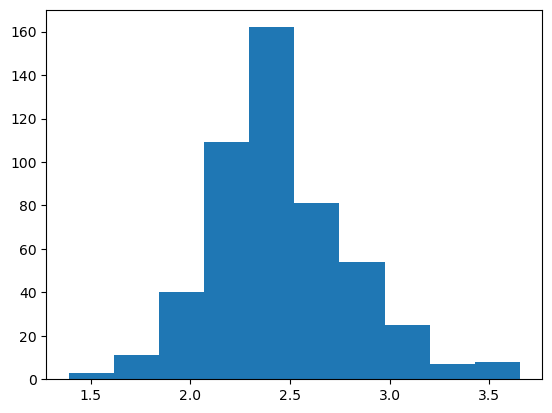

Parameter 1 = 0.14419264494602782 +/- 0.021330351400231734


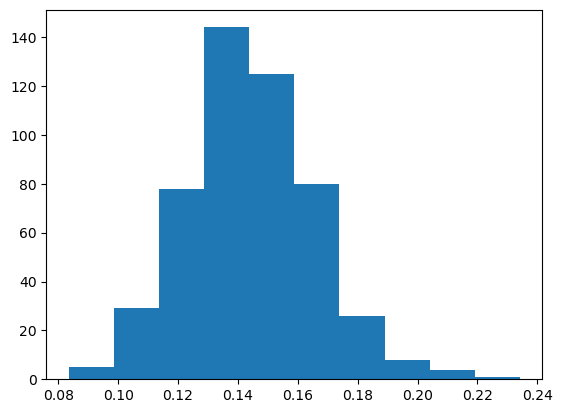

Parameter 2 = -0.005639332135872371 +/- 0.0033758162549742464


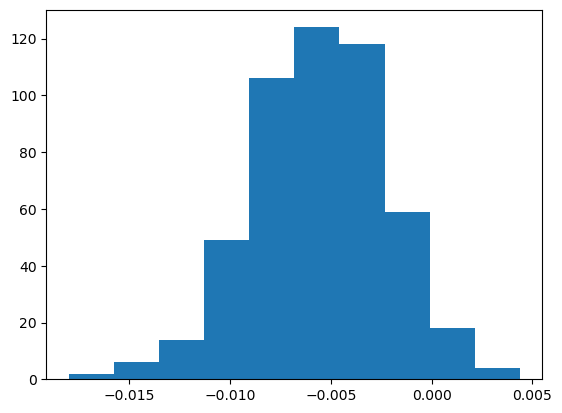

In [23]:
for i in range(len(bparams[0,:])):
    pd = bparams[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parameter {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()


B: parameter 1

$\alpha_1$: parameter 2

$\alpha_2$: parameter 3

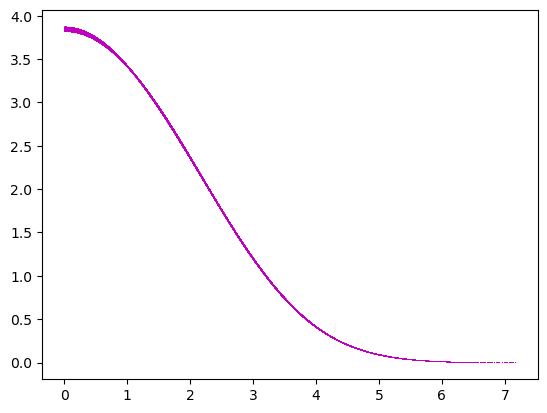

In [24]:
# now plot the new data 
for i in range(len(bcs)):    
    plt.scatter(zsparse_all,bcs[i],s=0.1,lw=0.1,c='m')
plt.show()

### Calculating osmotic pressure and osmotic coefficients 

In [25]:
def osmotic_pressure(cs,params, nu=2):
    """
    Funciton to calculate osmotic pressure and osmotic coefficients.
    """
    term1 = cs
    term2 = params[1]*0.5*cs**2
    term3 = params[2]*(1/3.0)*cs**3
    csh = np.sqrt(cs)
    B = params[0]
    Bf = 1+B*csh
    term4 = (A/B**2)*((2/B)*np.log(Bf) - (2*csh+B*cs)/Bf)    
    p = nu*R*T*(term1+term2+term3+term4) #osmotic pressure
    ip = nu*R*T*cs  # ideal osmotic pressure
    return p,p/ip # osmotic pressure, osmotic coefficient

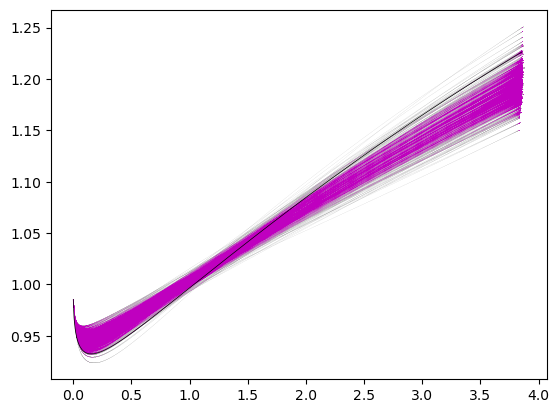

In [26]:
# scatter plots of the osmotic coefficients and osmotic pressures
ops = list()
ocs = list()
for p,c in zip(bparams,bcs):
    op,oc = osmotic_pressure(c,p)
    plt.scatter(c,oc,s=0.1,lw=0.1,alpha=0.01,c='m')
    ops.append(op)
    ocs.append(oc)
opt_oc = osmotic_pressure(c_opt_sparse_all,full_opt)[1]
opt_op = osmotic_pressure(c_opt_sparse_all,full_opt)[0]
plt.plot(c_opt_sparse_all,opt_oc,'k',lw=0.5,)
ops = np.array(ops)
ocs = np.array(ocs)
plt.show()

In [27]:
def find_closest(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    closest_value = lst[closest_index]
    return closest_index, closest_value

In [28]:
lower_bound_1sigma = np.percentile(ocs, 16, axis=0)
upper_bound_1sigma = np.percentile(ocs, 84, axis=0)

target_values = [0.976,1.923,2.823] # 1 molal, 2 molal, 3 molal concentrations in units of molar
closest_indexes=[]

# Osmotic coefficient results:
for target_value in target_values:
    closest_index, closest_value = find_closest(c_opt_sparse_all, target_value)
    lower_bound_1sigma = np.percentile(ocs, 16, axis=0)
    upper_bound_1sigma = np.percentile(ocs, 84, axis=0)
    y_values = opt_oc[closest_index]
    y_error_lower = (y_values - lower_bound_1sigma[closest_index])
    y_error_upper = (upper_bound_1sigma[closest_index] - y_values) 
    uncertainity=(y_error_lower+y_error_upper)/2
    closest_indexes.append(closest_index)
    print(f"The closest value to {target_value} is {closest_value} at index {closest_index} and osmotic coefficient is {opt_oc[closest_index]} +/- {uncertainity}")

# Osmotic pressure results:
for target_value in target_values:
    closest_index, closest_value = find_closest(c_opt_sparse_all, target_value)
    lower_bound_1sigma = np.percentile(ops, 16, axis=0)
    upper_bound_1sigma = np.percentile(ops, 84, axis=0)
    y_values = opt_op[closest_index]
    y_error_lower = (y_values - lower_bound_1sigma[closest_index])
    y_error_upper = (upper_bound_1sigma[closest_index] - y_values) 
    uncertainity=(y_error_lower+y_error_upper)/2
    print(f"The closest value to {target_value} is {closest_value} at index {closest_index} and osmotic pressure is {opt_op[closest_index]/100} +/- {uncertainity/100}")

The closest value to 0.976 is 0.975888729095459 at index 5990 and osmotic coefficient is 0.9944226145744324 +/- 0.004002890009405624
The closest value to 1.923 is 1.9235247373580933 at index 4362 and osmotic coefficient is 1.0781959295272827 +/- 0.0067287317081354825
The closest value to 2.823 is 2.8230090141296387 at index 2938 and osmotic coefficient is 1.151239037513733 +/- 0.010856164065089047
The closest value to 0.976 is 0.975888729095459 at index 5990 and osmotic pressure is 48.4124169921875 +/- 0.25285415420617935
The closest value to 1.923 is 1.9235247373580933 at index 4362 and osmotic pressure is 103.462001953125 +/- 0.5279349378493225
The closest value to 2.823 is 2.8230090141296387 at index 2938 and osmotic pressure is 162.12994140625 +/- 1.2666588383118778


### Plotting

In [ ]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

In [ ]:
# Uncertainty precision options
lower_bound_95 = np.percentile(ocs, 2.5, axis=0)
upper_bound_95 = np.percentile(ocs, 97.5, axis=0)

lower_bound_1sigma = np.percentile(ocs, 16, axis=0)
upper_bound_1sigma = np.percentile(ocs, 84, axis=0)

NameError: name 'lower_bound_95' is not defined

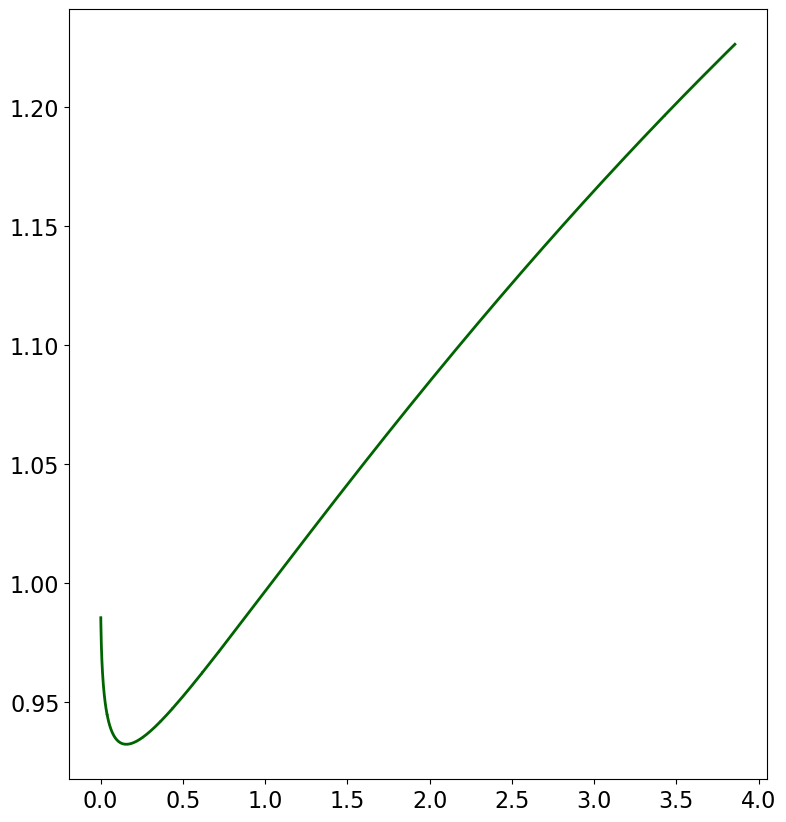

In [29]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))
plt.plot(c_opt_sparse_all, opt_oc, lw=2, label='Maximum Likelihood Estimate - Sage 2.1', color='darkgreen')
plt.fill_between(c_opt_sparse_all, lower_bound_95, upper_bound_95, color='g', alpha=0.2, label='95% Confidence Interval')
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel('Osmotic Coefficients', fontsize=MEDIUM_SIZE)
plt.legend()
plt.xlim(0.0,3.5)
plt.ylim(0.92,1.22)
plt.title('Osmotic Coefficients From Harmonic Potential', fontsize=BIGGER_SIZE)
plt.savefig('oc.png', dpi=1000)
plt.show()

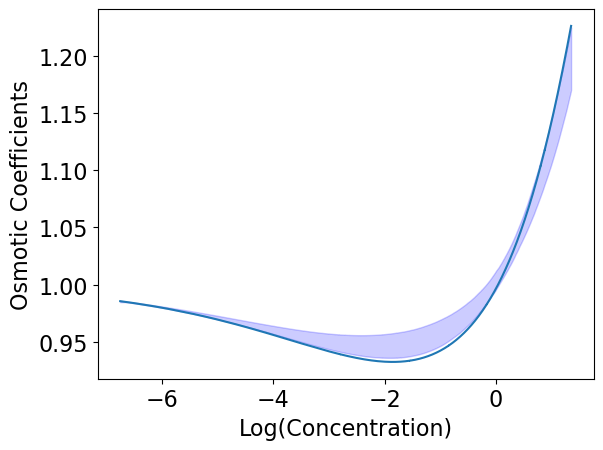

In [ ]:

plt.plot(np.log(c_opt_sparse_all), opt_oc, label='Mean Profile')
plt.fill_between(np.log(c_opt_sparse_all), lower_bound_95, upper_bound_95, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Log(Concentration)')
plt.ylabel('Osmotic Coefficients')
plt.show()